In [14]:
from Embedders import get_embedder
from TextEnrichers import get_enricher
from database.database import Database
import torch
import pandas as pd
import numpy as np

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'
bge_embedder = get_embedder(model_name="BAAI/bge-small-en", device=device, normalize=True)

examples = pd.read_json('data/dataset/100/nontrivial.jsonl', lines=True)
db = Database()
db.test_connection()

=================================CONFIG=================================
Database         User             Host                             Port            
citeline_db      bbasseri         localhost                        5432            
Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)


In [27]:
example = examples.iloc[29]
print(example)

source_doi                         10.1146/annurev.aa.30.090192.000553
sent_original        The work of Widing & Feldman (1989) suggests a...
sent_no_cit          The work of  suggests a fundamental distinctio...
sent_idx                                                           369
citation_dois                                         [10.1086/167871]
pubdate                                                     1992-01-01
resolved_bibcodes                                [1989ApJ...344.1046W]
Name: 29, dtype: object


Let's query the database on vector distance to get the top k results for this example and investigate the distances to chunks from the target doi

In [28]:
db.set_session_resources(optimize_for="query")
query_vector = bge_embedder([example.sent_no_cit])[0]
query_results = db.query_vector_column(
    query_vector=query_vector,
    table_name='lib',
    target_column='bge_norm',
    pubdate=example.pubdate,
    use_index=True,
    top_k=10000,
    probes=50
)

Executing query:

                -- SET synchronous_commit = 'off';
                SET maintenance_work_mem = '1GB';
                -- SET random_page_cost = '1.1';
                -- SET parallel_tuple_cost = '0.1';
                -- SET parallel_setup_cost = '1000';
                SET max_parallel_workers = 10;
                SET work_mem = '4.0GB';
                SET max_parallel_workers_per_gather = 10;
                SET effective_cache_size = '64GB';
            


In [30]:
target_doi = example.citation_dois[0]
target_at_indices = []
print(f"Target doi: {target_doi}")
for i, result in enumerate(query_results):
    if result.doi == target_doi:
        print(f"Found target doi at index {i}")
        target_at_indices.append(i)

Target doi: 10.1086/167871
Found target doi at index 35
Found target doi at index 60
Found target doi at index 161
Found target doi at index 241
Found target doi at index 390
Found target doi at index 774
Found target doi at index 1119
Found target doi at index 1387
Found target doi at index 1668
Found target doi at index 1959
Found target doi at index 3414


Now let's enrich the query text with 'title' and see how much its embedding moves from the original (identity) embedding

In [33]:
title_enricher = get_enricher('add_title', path_to_data='data/preprocessed/reviews.jsonl')

In [36]:
example_df = pd.DataFrame([example])
print(example_df)

                             source_doi  \
29  10.1146/annurev.aa.30.090192.000553   

                                        sent_original  \
29  The work of Widing & Feldman (1989) suggests a...   

                                          sent_no_cit  sent_idx  \
29  The work of  suggests a fundamental distinctio...       369   

       citation_dois     pubdate      resolved_bibcodes  
29  [10.1086/167871]  1992-01-01  [1989ApJ...344.1046W]  


In [38]:
for thing in example_df.itertuples():
    print(thing)

Pandas(Index=29, source_doi='10.1146/annurev.aa.30.090192.000553', sent_original='The work of Widing & Feldman (1989) suggests a fundamental distinction in elemental abundances between closed and open magnetic structures, matching the nominal photospheric and coronal abundances, respectively.', sent_no_cit='The work of  suggests a fundamental distinction in elemental abundances between closed and open magnetic structures, matching the nominal photospheric and coronal abundances, respectively.', sent_idx=369, citation_dois=['10.1086/167871'], pubdate='1992-01-01', resolved_bibcodes=['1989ApJ...344.1046W'])


In [42]:
enriched_query = title_enricher(example_df)
print(enriched_query)
enriched_query_vector = bge_embedder(enriched_query)[0]

['IMPORTANT:\nThe work of  suggests a fundamental distinction in elemental abundances between closed and open magnetic structures, matching the nominal photospheric and coronal abundances, respectively.\n\nTitle:\nSolar flares and coronal mass ejections.']


In [47]:
print(enriched_query_vector.shape)
print(query_vector.shape)

def cosine_distance(a: np.array, b: np.array):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

print(cosine_distance(query_vector, enriched_query_vector))

(384,)
(384,)
0.04776597023010254


In [ ]:
# Get the vectors for the query results
result_vectors = []
for result in query_results:
    res = db.query(f"""SELECT bge_norm FROM lib WHERE id = {result.chunk_id}""")
    if len(res) != 1:
        print(f"Error: {len(res)} results for id {result.chunk_id}")
        continue
    # Result is a list of tuples
    result_vectors.append(res[0][0])

In [57]:
print(type(result_vectors[0]))
print(result_vectors[0].shape)

<class 'numpy.ndarray'>
(384,)


In [59]:
for i in range(100):
    query_result = query_results[i]
    original_distance = query_result.distance
    result_vector = result_vectors[i]
    enriched_distance = cosine_distance(result_vector, enriched_query_vector)
    print(f"{i}: Original d: {original_distance}, Enriched d: {enriched_distance}, Change: {original_distance - enriched_distance}")

0: Original d: 0.12854576877030943, Enriched d: 0.08943033218383789, Change: 0.03911543658647154
1: Original d: 0.12875569634172102, Enriched d: 0.09762436151504517, Change: 0.03113133482667585
2: Original d: 0.12915461485656254, Enriched d: 0.09398019313812256, Change: 0.035174421718439985
3: Original d: 0.12937322925807748, Enriched d: 0.09141826629638672, Change: 0.037954962961690764
4: Original d: 0.12979995430708047, Enriched d: 0.08408993482589722, Change: 0.04571001948118325
5: Original d: 0.13001741528716182, Enriched d: 0.0951153039932251, Change: 0.03490211129393672
6: Original d: 0.13021620983690363, Enriched d: 0.0876990556716919, Change: 0.042517154165211735
7: Original d: 0.13062485408031432, Enriched d: 0.09362387657165527, Change: 0.03700097750865905
8: Original d: 0.13236093521117542, Enriched d: 0.10059964656829834, Change: 0.031761288642877084
9: Original d: 0.1328552723785732, Enriched d: 0.087810218334198, Change: 0.0450450540443752
10: Original d: 0.13287448883056

In [71]:
from Rerankers import entailment_ranker
roberta_nli_ranker = entailment_ranker("cross-encoder/nli-roberta-base")

In [81]:
# NLI confidence on highest-ranked chunk from the target document (35):
conf = roberta_nli_ranker(query_results[35].chunk, example.sent_no_cit)
print(f"Confidence: {conf}")

Confidence: 0.46278029680252075


In [85]:
# Number of higher confidences than that:
print(sum([1 for c in nli_scores[:40] if c >= conf]))

1


In [ ]:
reranked = sorted(query_results, key=lambda res: roberta_nli_ranker(res.chunk, example.sent_no_cit), reverse=True)

In [73]:
# For the query results, use each chunk as the premise and the query text as the hypothesis
nli_scores = []
for i, result in enumerate(query_results[:3000]):
    score = roberta_nli_ranker(
        premise=result.chunk,
        hypothesis=example.sent_no_cit
    )
    print(f"{i}: Entailment score: {score}")
    nli_scores.append(score)

0: Entailment score: 0.05895661562681198
1: Entailment score: 0.029541701078414917
2: Entailment score: 0.1235370859503746
3: Entailment score: 0.08199542760848999
4: Entailment score: 0.011439955793321133
5: Entailment score: 0.011133894324302673
6: Entailment score: 0.0065533071756362915
7: Entailment score: 0.15494462847709656
8: Entailment score: 0.031048426404595375
9: Entailment score: 0.03628990054130554
10: Entailment score: 0.3801825940608978
11: Entailment score: 0.021578921005129814
12: Entailment score: 0.2669388949871063
13: Entailment score: 0.0033624705392867327
14: Entailment score: 0.008104251697659492
15: Entailment score: 0.2106063961982727
16: Entailment score: 0.11443139612674713
17: Entailment score: 0.0038167238235473633
18: Entailment score: 0.008385281078517437
19: Entailment score: 0.060971569269895554
20: Entailment score: 0.007788721472024918
21: Entailment score: 0.011334294453263283
22: Entailment score: 0.07607313990592957
23: Entailment score: 0.08590053

In [77]:
max(nli_scores)

0.8144668936729431

In [76]:
top_3000 = query_results[:3000]
sorted_top_3000 = [result for result, _ in sorted(zip(top_3000, nli_scores), key=lambda x: x[1])]
print("Top 10 results:")
for i, result in enumerate(sorted_top_3000[:10]):
    print(f"{i}: {result.chunk_id}, {result.doi}, {result.distance}")

Top 10 results:
0: 1201484, 10.1086/185806, 0.1561650075322123
1: 1686876, 10.1093/mnras/183.2.79, 0.1657533349239808
2: 353318, 10.1146/annurev.aa.12.090174.001531, 0.1583170011668784
3: 1186524, 10.1086/114402, 0.1635754108428895
4: 2055680, 10.1086/183266, 0.158764412476752
5: 855830, 10.1086/166800, 0.1599506044417245
6: 1298703, 10.1086/191001, 0.16371367410258364
7: 1865903, 10.1103/RevModPhys.47.877, 0.14923906326293346
8: 543580, 10.1016/0019-1035(69)90094-3, 0.16567399604099664
9: 1735267, 10.1093/mnras/220.4.1021, 0.15518598155848173


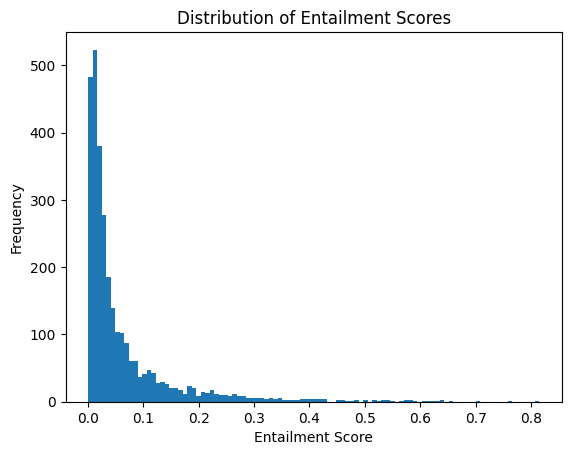

In [80]:
import matplotlib.pyplot as plt
plt.hist(nli_scores, bins=100)
plt.xlabel('Entailment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Entailment Scores')
plt.show()

In [ ]:
reranks = []
for example in examples.itertuples():
    query_text = example.sent_no_cit

['10.1016/j.epsl.2013.07.013']
['10.1086/505649']
['10.3847/1538-4357/abec4f']
['10.1051/0004-6361/201527616']
['10.1086/305263']
['10.48550/arXiv.astro-ph/9302006']
['10.1016/j.jseaes.2012.12.020']
['10.1111/j.1365-2966.2011.19385.x']
['10.1088/1475-7516/2012/07/038']
['10.1086/309935']
['10.1016/j.gca.2021.07.031']
['10.1086/151310']
['10.3847/1538-4357/ab1f84']
['10.1086/380430']
['10.1016/j.jafrearsci.2008.01.004']
['10.1111/j.1365-2966.2008.13111.x']
['10.1088/2041-8205/739/2/L37']
['10.1088/2041-8205/779/2/L22']
['10.1046/j.1365-8711.2002.05438.x']
['10.1023/A:1005033717284']
['10.1038/ngeo1475', '10.1016/j.gloplacha.2010.03.011']
['10.1088/0067-0049/180/2/330']
['10.1086/182092', '10.1086/155470']
['10.1093/mnras/stz2467']
['10.1016/j.advwatres.2009.05.006']
['10.1038/nature04122']
['10.1016/0021-9169(74)90074-9']
['10.1103/PhysRevFluids.4.013803']
['10.1086/164076']
['10.1086/167871']
['10.1086/503273', '10.1088/0004-637X/697/2/1741']
['10.1088/2041-8205/787/1/L2']
['10.1007/BF

In [89]:
doi_articles = pd.read_json('data/json/doi_articles.json')
doi_articles.head()

,bibcode,abstract,aff,author,bibstem,doctype,doi,id,keyword,pubdate,title,read_count,reference,data,citation_count,citation,body
0,2001MNRAS.322..231K,A universal initial mass function (IMF) is not...,[Institut für Theoretische Physik und Astrophy...,"[Kroupa, Pavel]","[MNRAS, MNRAS.322]",article,"[10.1046/j.1365-8711.2001.04022.x, 10.48550/ar...",11725321,"[BINARIES: GENERAL, STARS: FORMATION, STARS: K...",2001-04-00,[On the variation of the initial mass function],242,"[1955ApJ...121..161S, 1974A&A....37..183A, 197...",[SIMBAD:9],6311,"[2000A&A...363..970C, 2001A&A...372..851A, 200...","Mon. Not. R. Astron. Soc. 322, 231±246 (2001) ..."
1,1970ApJ...160..811F,Surface photometry shows that most spiral and ...,[-],"[Freeman, K. C.]","[ApJ, ApJ...160]",article,[10.1086/150474],1218785,NaN,1970-06-00,[On the Disks of Spiral and S0 Galaxies],31,"[1920ApJ....52..162S, 1926ApJ....64..321H, 194...","[NED:26, SIMBAD:36]",2468,"[1970ApJ...160..831S, 1971A&A....10..437B, 197...",197 OApJ. . .160. .811F The Astrophysical Jour...
2,2004A&A...428..261L,We present here a new solution for the astrono...,"[Astronomie et Systèmes Dynamiques, IMCCE - CN...","[Laskar, J., Robutel, P., Joutel, F., Gastinea...","[A&A, A&A...428]",article,[10.1051/0004-6361:20041335],2316985,"[chaos, celestial mechanics, ephemerides, Earth]",2004-12-00,[A long-term numerical solution for the insola...,3,"[1976eioh.book.....J, 1980esvr.book.....L, 200...",NaN,2825,"[2005AJ....130.1267B, 2005Geo....33..789C, 200...","No Title AA 428, 261-285 (2004) DOI: 10.1051/0..."
3,1995ARA&A..33..581K,Dynamical searches reveal central dark objects...,"[-, -]","[Kormendy, John, Richstone, Douglas]","[ARA&A, ARA&A..33]",article,[10.1146/annurev.aa.33.090195.003053],1952301,NaN,1995-00-00,[Inward Bound---The Search For Supermassive Bl...,72,"[1958ApJ...128..465D, 1960PASP...72...76L, 196...","[NED:8, SIMBAD:9]",2308,"[1995AJ....110.2700V, 1996A&ARv...7..289M, 199...",Annu. Rev. Astmn. Astrophys. 1995. 33:581-624 ...
4,1977ApJ...218..377W,The detailed structure of the interaction of a...,"[Colorado, University; Joint Institute for Lab...","[Weaver, R., McCray, R., Castor, J., Shapiro, ...","[ApJ, ApJ...218]",article,[10.1086/155692],1364322,"[Interstellar Gas, Plasma Interactions, Stella...",1977-12-00,[Interstellar bubbles. II. Structure and evolu...,45,"[1950RSPSA.201..159T, 1962pfig.book.....S, 196...",[SIMBAD:1],1959,"[1978A&A....68..189G, 1978Ap&SS..59..193M, 197...",1977ApJ. . .218. .377W The Astrophysical Journ...
